# Feature engineering for House Price modelling

In this notebook, I will bring together various techniques for feature engineering to tackle a regression problem. I hope to give you a flavour of how to approach the end-to-end pipeline to build machine learning algorithms for regression.

For more feature engineering techniques, check my new course [Feature Engineering for Machine Learning](https://www.udemy.com/feature-engineering-for-machine-learning/?couponCode=PROMO_KGG), which was recently launched on Udemy.

In [14]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# for variable transformation
import scipy.stats as stats

# to build the models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
#import xgboost as xgb

# to evaluate the models
from sklearn.metrics import mean_squared_error

pd.pandas.set_option('display.max_columns', None)

In [15]:
# load dataset
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
# Load the dataset for submission (the one on which our model will be evaluated by Kaggle)
# it contains exactly the same variables, but not the target

#submission = pd.read_csv("../input/test.csv")
#submission.head()

The House Price dataset  contains 80 different variables. We could potentially investigate each one of them individually, and I think that in a business scenario this would be the right way to proceed, as they are actually not that many. However, for the purpose of this notebook, I will try to automate the feature engineering pipeline, making some a priori decisions on when I will apply one feature engineering technique or the other.

There are other good visualisation notebooks in Kaggle that you can check to get more familiar of how the variables look like.

### Types of variables

Let's go ahead and find out what types of variables there are in this dataset

In [17]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [18]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 38 numerical variables


Numerical variables can be binary, continuous or discrete. A priori, it is good practice to know what each variable means, to then be able to differentiate continuous from discrete variables. In this notebook, I will assume that variables with a definite and low number of unique values are discrete.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [19]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(data[var].unique())<20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
There are 15 discrete variables


As you can see there are a number of discrete variables in the dataset,  for example BedroomAbvGr, with the values indicating the number of bedrooms in the House.

### Types of problems the variables may present

#### Missing values

In [20]:
# let's visualise the percentage of missing values
for var in data.columns:
    if data[var].isnull().sum()>0:
        print(var, data[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


There are a few variables that contain missing information (NaN). Some of them contain a lot of missing values, and some of them only a few. Let's first identify those that contain a lot of NaN and then see how we can process the different variables.

In [21]:
# let's inspect the type of those variables with a lot of missing information
for var in data.columns:
    if data[var].isnull().mean()>0.80:
        print(var, data[var].unique())

Alley [nan 'Grvl' 'Pave']
PoolQC [nan 'Ex' 'Fa' 'Gd']
Fence [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
MiscFeature [nan 'Shed' 'Gar2' 'Othr' 'TenC']


The ones with high percentage of missing data are categorical variables. We will need to fill those out.

#### Outliers

Let's find out now if the variables contain outliers.

In [22]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice']]
continuous

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


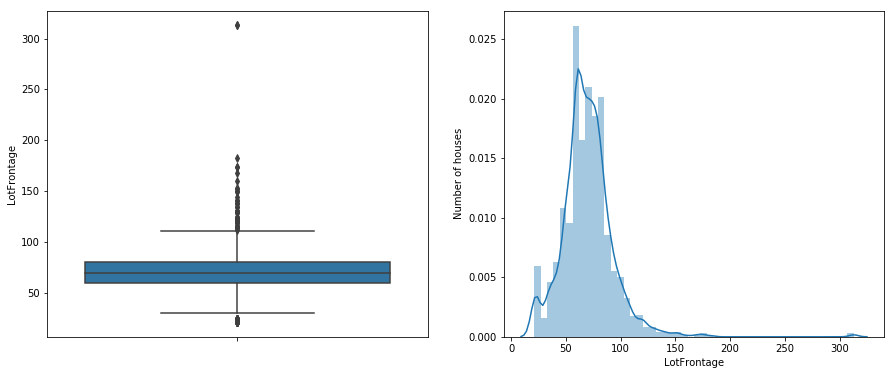

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


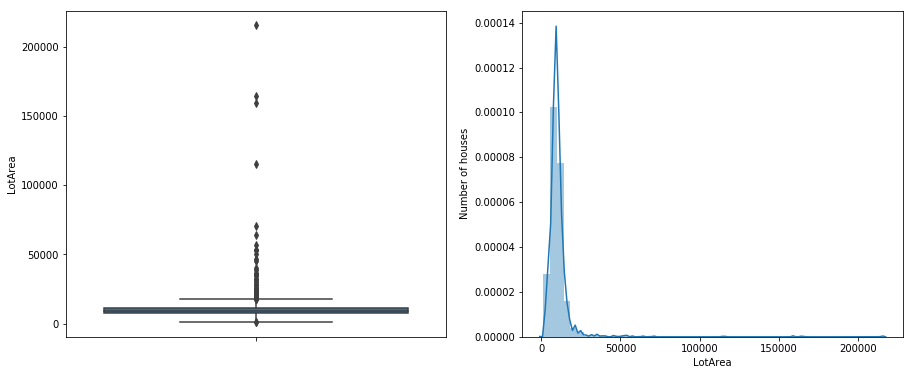

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


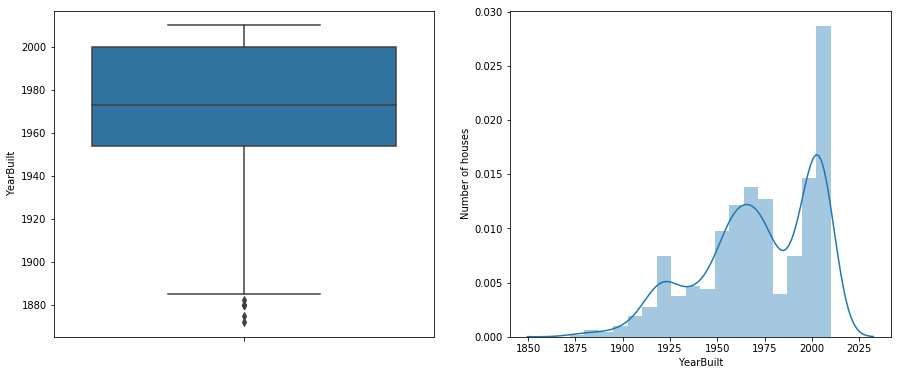

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


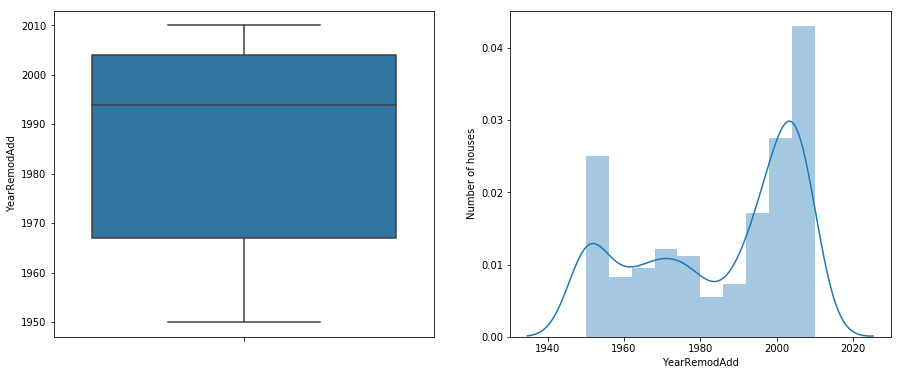

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


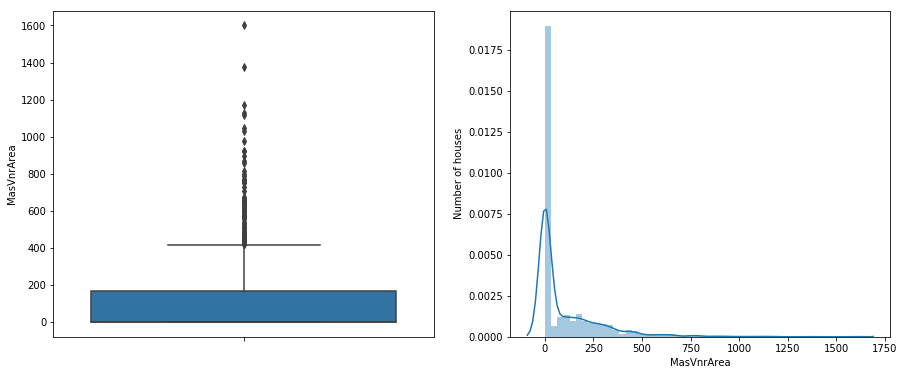

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


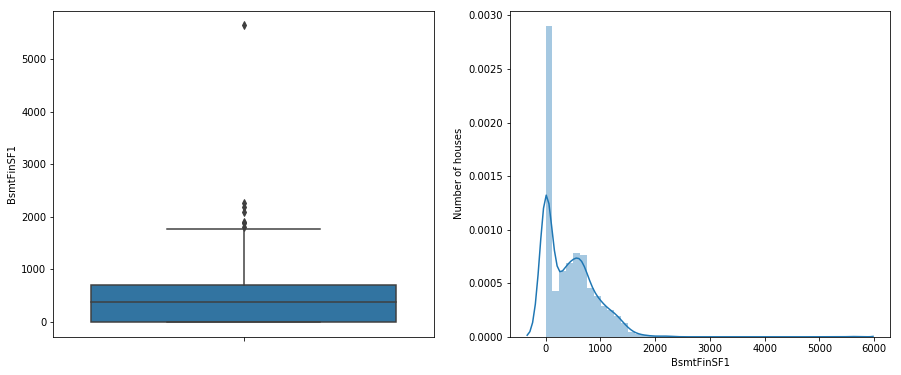

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


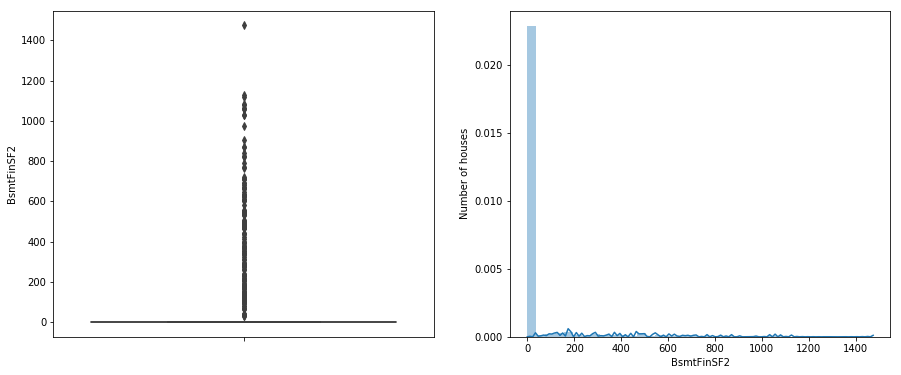

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


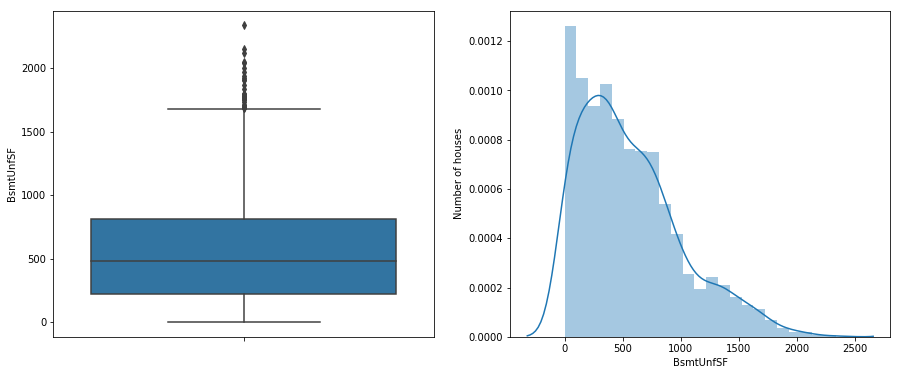

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


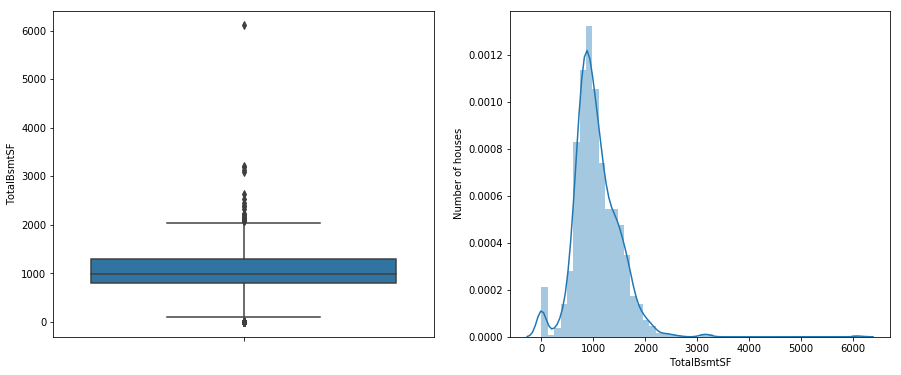

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


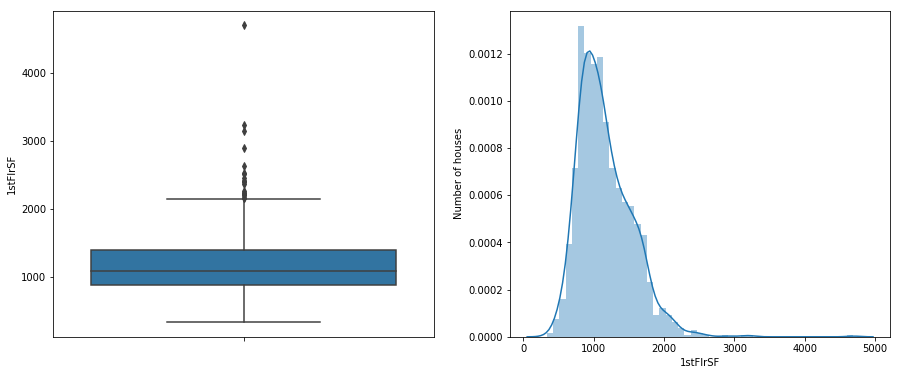

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


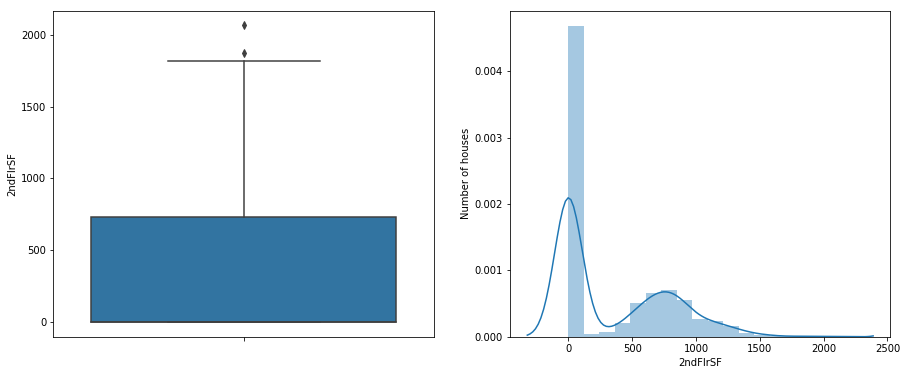

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


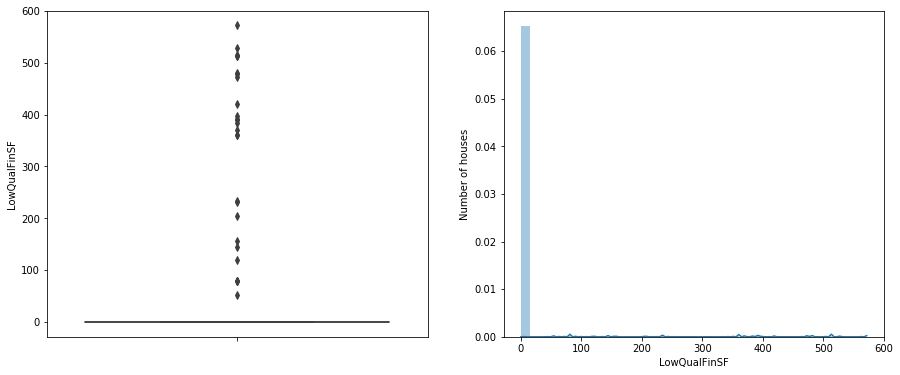

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


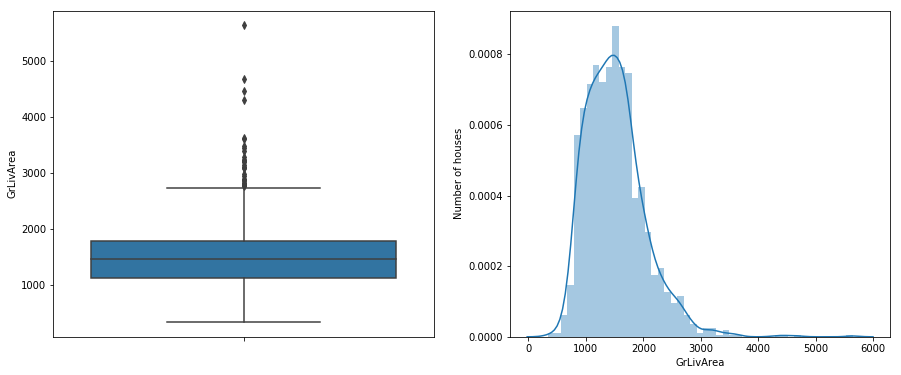

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


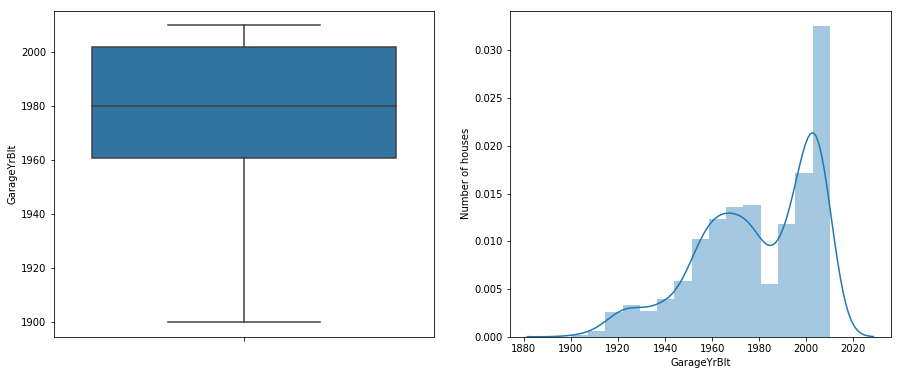

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


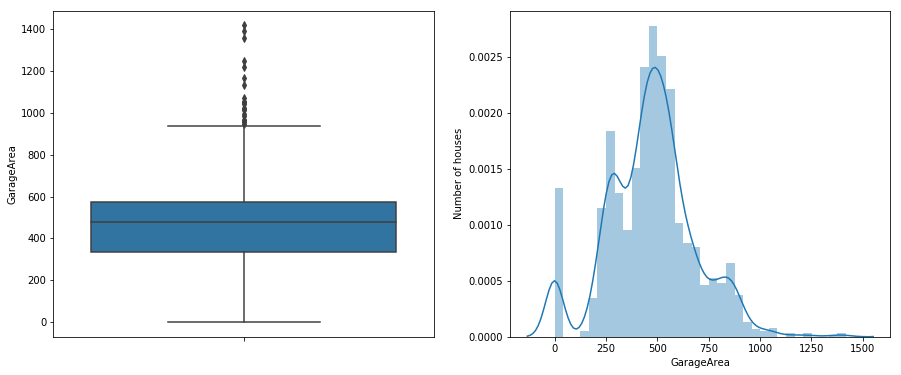

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


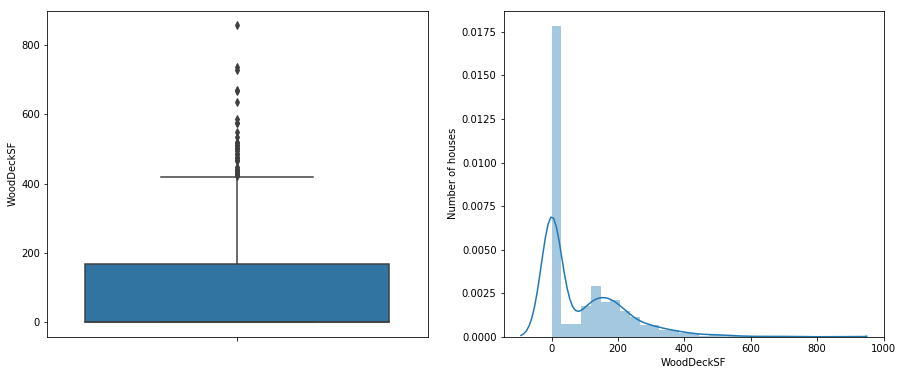

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


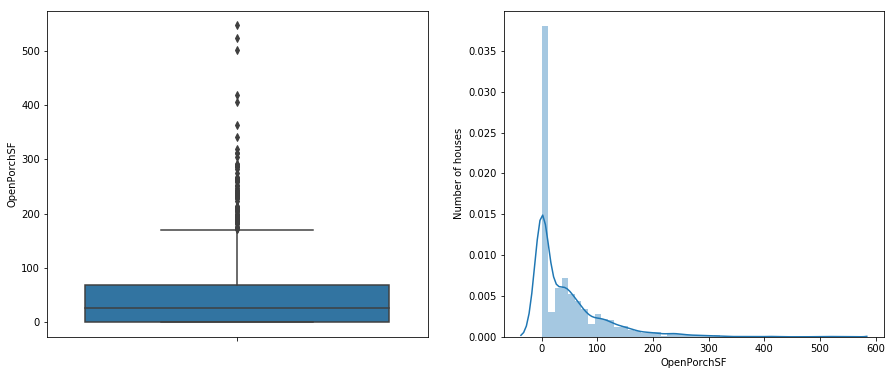

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


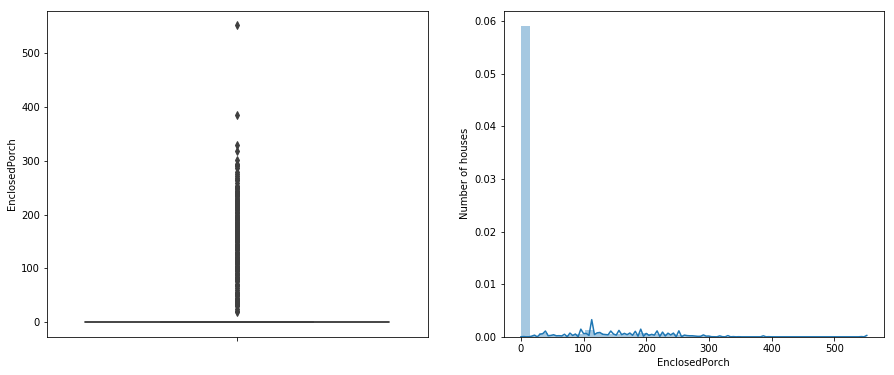

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


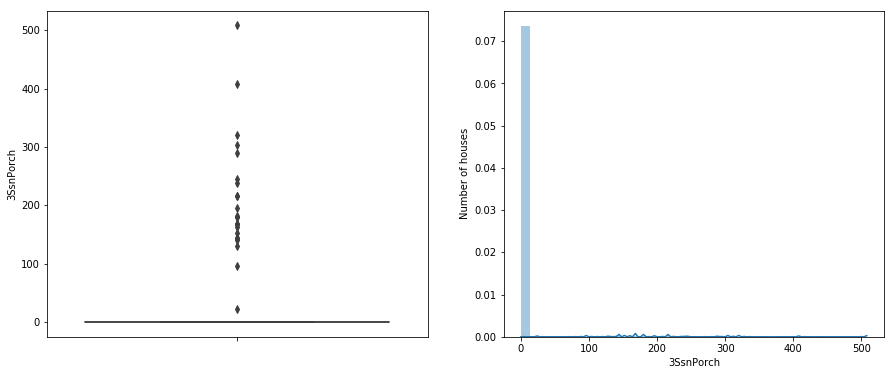

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


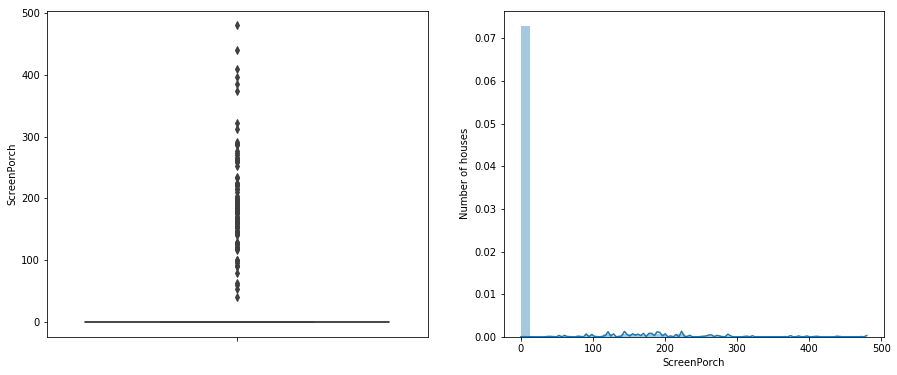

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


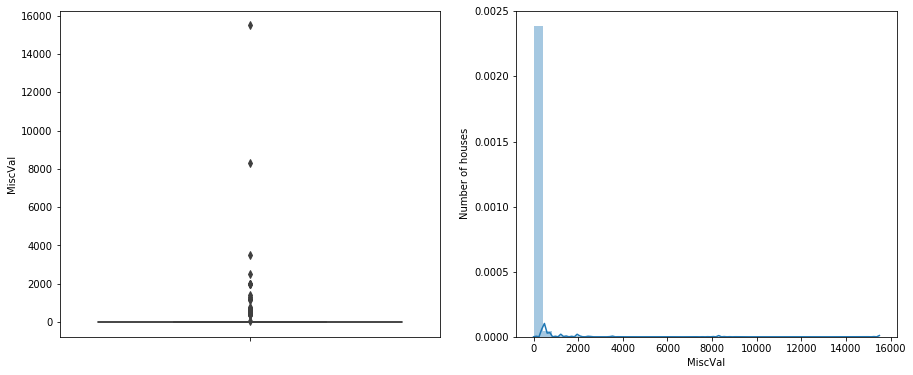

In [23]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=data[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(data[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

Outliers can be visualised as the dots outside the  whiskers in the boxplots. The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. If we are planning to build linear regression, we should tackle these to improve the model performance. I will transform the variables with a box cox to try and make them more "Gaussian" looking later on in the notebook.  I will not cover outlier removal in the notebook though.

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


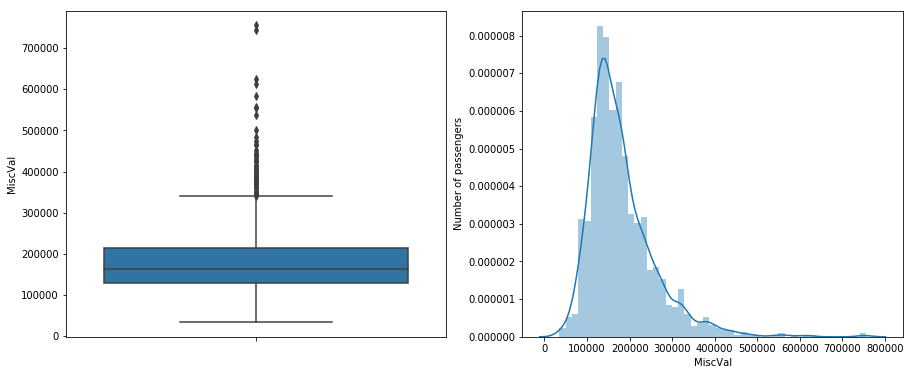

In [24]:
# let's look at the distribution of the target variable

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=data['SalePrice'])
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(data['SalePrice'].dropna())#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

The target variable is also skewed. So I will transform it as well to boost the performance of the algorithm.

#### Outlies in discrete variables

Let's calculate the percentage of houses for each  of the values that can take the discrete variables. I will call outliers, those values that are present in less than 1% of the houses.

In [25]:
# outlies in discrete variables
for var in discrete:
    print(data[var].value_counts() / np.float(len(data)))
    print()

20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64

5     0.271918
6     0.256164
7     0.218493
8     0.115068
4     0.079452
9     0.029452
3     0.013699
10    0.012329
2     0.002055
1     0.001370
Name: OverallQual, dtype: float64

5    0.562329
6    0.172603
7    0.140411
8    0.049315
4    0.039041
3    0.017123
9    0.015068
2    0.003425
1    0.000685
Name: OverallCond, dtype: float64

0    0.586301
1    0.402740
2    0.010274
3    0.000685
Name: BsmtFullBath, dtype: float64

0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64

2    0.526027
1    0.445205
3    0.022603
0    0.006164
Name: FullBath, dtype: float64

0    0.625342
1    0.366438
2    0.008219
Name: HalfBath, dtype: float64

3    0.550685
2    0.245205
4    0.145890
1    0

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset. For linear regression, this may not be a problem, but it most likely will be for tree methods. We should take this into account to improve the performance of our trees.


#### Number of labels: cardinality

Let's now check if our categorical variables have a huge number of categories. This may be a problem for some machine learning models.

In [26]:
for var in categorical:
    print(var, ' contains ', len(data[var].unique()), ' labels')

MSZoning  contains  5  labels
Street  contains  2  labels
Alley  contains  3  labels
LotShape  contains  4  labels
LandContour  contains  4  labels
Utilities  contains  2  labels
LotConfig  contains  5  labels
LandSlope  contains  3  labels
Neighborhood  contains  25  labels
Condition1  contains  9  labels
Condition2  contains  8  labels
BldgType  contains  5  labels
HouseStyle  contains  8  labels
RoofStyle  contains  6  labels
RoofMatl  contains  8  labels
Exterior1st  contains  15  labels
Exterior2nd  contains  16  labels
MasVnrType  contains  5  labels
ExterQual  contains  4  labels
ExterCond  contains  5  labels
Foundation  contains  6  labels
BsmtQual  contains  5  labels
BsmtCond  contains  5  labels
BsmtExposure  contains  5  labels
BsmtFinType1  contains  7  labels
BsmtFinType2  contains  7  labels
Heating  contains  6  labels
HeatingQC  contains  5  labels
CentralAir  contains  2  labels
Electrical  contains  6  labels
KitchenQual  contains  4  labels
Functional  contains  7 

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Variables with high cardinality may affect the performance of some machine learning models, for example trees.

### Separate train and test set

In [27]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data, data.SalePrice, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape

((1168, 81), (292, 81))

### Engineering missing values in numerical variables
#### Continuous variables

In [28]:
# print variables with missing data
for col in continuous:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.1815068493150685
MasVnrArea 0.005136986301369863
GarageYrBlt 0.04965753424657534


- LotFrontage and GarageYrBlt contain a relatively high percentage of missing values, therefore I will create and additional variable to indicate NA, and then I will do median imputation on the original variable.
- CMasVnrArea contains a small percentage of missing values, thus I will just do median imputation

In [31]:
# add variable indicating missingness + median imputation
for df in [X_train, X_test]:
    for var in ['LotFrontage', 'GarageYrBlt']:
        df[var+'_NA'] = np.where(df[var].isnull(), 1, 0)
        df[var].fillna(X_train[var].median(), inplace=True) 

for df in [X_train, X_test]:
    df.MasVnrArea.fillna(X_train.MasVnrArea.median(), inplace=True)

C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\9390\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


#### Discrete variables

In [32]:
# print variables with missing data
for col in discrete:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

There are no missing data in the discrete variables. Good, then we don't have to engineer them.

### Engineering Missing Data in categorical variables

In [33]:
# print variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

Alley 0.9392123287671232
MasVnrType 0.005136986301369863
BsmtQual 0.023972602739726026
BsmtCond 0.023972602739726026
BsmtExposure 0.023972602739726026
BsmtFinType1 0.023972602739726026
BsmtFinType2 0.02482876712328767
Electrical 0.0008561643835616438
FireplaceQu 0.4717465753424658
GarageType 0.04965753424657534
GarageFinish 0.04965753424657534
GarageQual 0.04965753424657534
GarageCond 0.04965753424657534
PoolQC 0.9965753424657534
Fence 0.8167808219178082
MiscFeature 0.9580479452054794


I will add a 'Missing' Label to all of them. If the missing data are rare, I will handle those together with rare labels in a subsequent engineering step.

In [ ]:
# add label indicating 'Missing' to categorical variables

for df in [X_train, X_test, submission]:
    for var in categorical:
        df[var].fillna('Missing', inplace=True)

In [ ]:
# check absence of null values
for var in X_train.columns:
    if X_train[var].isnull().sum()>0:
        print(var, X_train[var].isnull().sum())

In [ ]:
# check absence of null values
for var in X_train.columns:
    if X_test[var].isnull().sum()>0:
        print(var, X_test[var].isnull().sum())

In [ ]:
# check absence of null values
submission_vars = []
for var in X_train.columns:
    if var!='SalePrice' and submission[var].isnull().sum()>0:
        print(var, submission[var].isnull().sum())
        submission_vars.append(var)

This is something important. There are variables in the submission dataset that contain null values (missing data), where in the training set they did not.  This needs to be taken into consideration at the time of making predictions, or deploying models in business scenarios.

In [ ]:
#  I will replace NAN by the median 
for var in submission_vars:
    submission[var].fillna(X_train[var].median(), inplace=True)

### Transformation of Numerical variables 

As most variables were skewed, I will transform them with the box cox transformation.

In [ ]:
def boxcox_transformation(var):
    X_train[var], param = stats.boxcox(X_train[var]+1) 
    X_test[var], param = stats.boxcox(X_test[var]+1) 
    submission[var], param = stats.boxcox(submission[var]+1) 

In [ ]:
for var in continuous:
    boxcox_transformation(var)
    
X_train[continuous].head()

In [ ]:
# let's  check if the transformation created infinite values
for var in continuous:
    if np.isinf(X_train[var]).sum()>1:
        print(var)

In [ ]:
for var in continuous:
    if np.isinf(X_test[var]).sum()>1:
        print(var)

In [ ]:
for var in continuous:
    if np.isinf(submission[var]).sum()>1:
        print(var)

In [ ]:
# check absence of null values(there should be none)
for var in X_train.columns:
    if X_test[var].isnull().sum()>0:
        print(var, X_test[var].isnull().sum())

In [ ]:
# let's make boxplots to visualise outliers in the continuous variables
# and histograms to get an idea of the distribution
# hopefully the transformation yielded variables more "Gaussian"looking


for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=X_train[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(X_train[var].dropna())#.hist(bins=20)
    fig.set_ylabel('Number of passengers')
    fig.set_xlabel(var)

    plt.show()

The boxcox transformation worked for some of the variables, and of course it did not for some others. Those for example where only one value was predominant could not be shaped into a Gaussian looking distribution.

Also, notice that there are still outliers in several of the variables. Ideally, we would like to remove them somehow.

### Normalisation of the target variable: SalePrice

In [ ]:
var = 'SalePrice'
y_train = np.log(y_train) 
y_test = np.log(y_test) 

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 2, 2)
fig = sns.distplot(y_train)#.hist(bins=20)
fig.set_ylabel('Number of passengers')
fig.set_xlabel(var)

plt.show()

The transformation of the Sale Variable worked quite well. It shows not a more Gaussian looking shape.

### Engineering rare labels in categorical and discrete variables

In [ ]:
def rare_imputation(variable):
    # find frequent labels / discrete numbers
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.03].index.values]
    
    X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
    submission[variable] = np.where(submission[variable].isin(frequent_cat), submission[variable], 'Rare')
    
# find unfrequent labels in categorical variables
for var in categorical:
    rare_imputation(var)
    
for var in ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']:
    submission[var] = submission[var].astype('int')


### Encode categorical variables

I will order the labels according to the target.

In [ ]:
def encode_categorical_variables(var, target):
        # make label to house price dictionary
        ordered_labels = X_train.groupby([var])[target].mean().sort_values().index
        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
        
        # encode variables
        X_train[var] = X_train[var].map(ordinal_label)
        X_test[var] = X_test[var].map(ordinal_label)
        submission[var] = submission[var].map(ordinal_label)

# encode labels in categorical vars
for var in categorical:
    encode_categorical_variables(var, 'SalePrice')


In [ ]:
for var in X_train.columns:
    if var!='SalePrice' and submission[var].isnull().sum()>0:
        print(var, submission[var].isnull().sum())

In [ ]:
# let's inspect the dataset
X_train.head()

### Feature scaling

In [ ]:
training_vars = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]

In [ ]:
# fit scaler
scaler = StandardScaler() # create an instance
scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set for later use

The scaler is now ready, we can use it in a machine learning algorithm when required. See below.

### Machine Learning algorithm building

#### xgboost

In [ ]:
xgb_model = xgb.XGBRegressor()

eval_set = [(X_test[training_vars], y_test)]
xgb_model.fit(X_train[training_vars], y_train, eval_set=eval_set, verbose=False)

pred = xgb_model.predict(X_train[training_vars])
print('xgb train mse: {}'.format(mean_squared_error(y_train, pred)))
pred = xgb_model.predict(X_test[training_vars])
print('xgb test mse: {}'.format(mean_squared_error(y_test, pred)))

#### Support vector classifier


In [ ]:
SVR_model = SVR()
SVR_model.fit(scaler.transform(X_train[training_vars]), y_train)

pred = SVR_model.predict(scaler.transform(X_train[training_vars]))
print('SVR train mse: {}'.format(mean_squared_error(y_train, pred)))
pred = SVR_model.predict(scaler.transform(X_test[training_vars]))
print('SVR test mse: {}'.format(mean_squared_error(y_test, pred)))

#### Regularised linear regression

In [ ]:
lin_model = Lasso(random_state=2909)
lin_model.fit(scaler.transform(X_train[training_vars]), y_train)

pred = lin_model.predict(scaler.transform(X_train[training_vars]))
print('linear train mse: {}'.format(mean_squared_error(y_train, pred)))
pred = lin_model.predict(scaler.transform(X_test[training_vars]))
print('linear test mse: {}'.format(mean_squared_error(y_test, pred)))

### Submission to Kaggle

In [ ]:
pred_ls = []
pred_ls.append(pd.Series(xgb_model.predict(submission[training_vars])))

pred = SVR_model.predict(scaler.transform(submission[training_vars]))
pred_ls.append(pd.Series(pred))

pred = lin_model.predict(scaler.transform(submission[training_vars]))
pred_ls.append(pd.Series(pred))

final_pred = np.exp(pd.concat(pred_ls, axis=1).mean(axis=1))

In [ ]:
temp = pd.concat([submission.Id, final_pred], axis=1)
temp.columns = ['Id', 'SalePrice']
temp.head()

### Conclusion

This solution is not one of the best ranking possible solutions. There is a lot more that can be done to try and improve the quality of the variables before using them in machine learning models. For example, instead of making box plot transformation for all of them, doing it just on those variables that benefit from it, and applying other techniques on the remaining ones, like for example discretisation. Discretisation also takes care of outliers, which do affect the performance of linear models. 

Variable selection is also an essencial step in the machine learning pipeline, which I have not covered in this notebook.

I hope you get a flavour of how to approach (or at least how I would approach) a machine learning problem and that you enjoyed the notebook.

Thanks for reading!
